In [ ]:
from google.cloud import bigquery

# Initialize a BigQuery client
client = bigquery.Client()

# Define your project, dataset, and table
project_id = "carbon-relic-439014-t0"
dataset_id = "chicago_taxi"
table_id = "data"

# Construct the fully qualified table name
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Load data into a Pandas DataFrame
query = f"SELECT * FROM `{table_ref}`"
df = client.query(query).to_dataframe()

# Display first few rows
print(df.head())


In [ ]:
df.describe()

In [ ]:
df.isna().sum()

In [ ]:
df.drop(columns=["pickup_census_tract", "dropoff_census_tract", "dropoff_community_area", "dropoff_latitude", "dropoff_longitude", "dropoff_location"], inplace=True)

In [ ]:
df.shape

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="trip_miles",y="trip_seconds")

In [ ]:
df = df[df["trip_miles"] < 400]

In [ ]:
df.shape

In [ ]:
sns.scatterplot(data=df, x="trip_miles",y="trip_seconds")

In [ ]:
df.head()

In [ ]:
df["daytime"] = df["trip_start_timestamp"].dt.hour
df['day_type'] = df['trip_start_timestamp'].dt.weekday.apply(lambda x: 'weekend' if x >= 5 else 'weekday')
df['month'] = df['trip_start_timestamp'].dt.month
df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek
df['day_of_month'] = df['trip_start_timestamp'].dt.day

In [ ]:
df.head()

In [ ]:
df["avg_tips_per_taxi"] = df.groupby("taxi_id")["tips"].transform("mean")
df_clean = df.drop(columns=["unique_key", "taxi_id", "trip_start_timestamp", "trip_end_timestamp", "timestamp", "fare", "tips", "trip_seconds", "pickup_location"])
df_clean.dropna(inplace=True)

In [ ]:
df_clean.head()

In [ ]:
df_clean.shape

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor

# Define categorical and numerical columns
categorical_cols = ["payment_type", "company", "day_type"]  # Replace with your actual categorical columns
numerical_cols = [ "trip_miles", "tolls", "extras", "daytime", "month", "day_of_week", "day_of_month",
                  "avg_tips_per_taxi", "pickup_latitude", "pickup_longitude", "pickup_community_area"]  # Replace with your actual numerical columns
target_column = "trip_total"

# Split data into features and target
X = df_clean.drop(columns=[target_column])
y = df_clean[target_column]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),  # Scale numerical columns
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)  # OneHotEncode categorical columns
])

# Define the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        objective="reg:squarederror"
    ))
])

import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train the pipeline (if not already trained)
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"mae: {mae}")
print(f"mse: {mse}")
print(f"rmse: {rmse}")
print(f"r2: {r2}")

# Log model hyperparameters (from XGBRegressor inside the pipeline)
xgb_params = pipeline.named_steps["model"].get_params()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from XGBoost model
feature_importances = pipeline.named_steps["model"].feature_importances_

# Retrieve transformed feature names from ColumnTransformer
encoder = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
ohe_feature_names = encoder.get_feature_names_out(categorical_cols)

# Combine numerical and encoded categorical feature names
all_feature_names = numerical_cols + list(ohe_feature_names)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": feature_importances
})

# Function to correctly map one-hot encoded features back to their original categorical column
def map_original_feature(feature_name):
    for cat_col in categorical_cols:
        if feature_name.startswith(cat_col + "_"):  # One-hot encoded feature
            return cat_col
    return feature_name  # Numerical features remain unchanged

# Apply the mapping function
feature_importance_df["Original Feature"] = feature_importance_df["Feature"].apply(map_original_feature)

# Aggregate importance scores by original feature names
aggregated_importance = feature_importance_df.groupby("Original Feature")["Importance"].sum().reset_index()

# Sort by importance
aggregated_importance = aggregated_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(aggregated_importance["Original Feature"], aggregated_importance["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Aggregated Feature Importance (Grouped)")
plt.gca().invert_yaxis()
plt.show()


In [78]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    exclude_cols = {"extras", "avg_tips", "pickup_latitude", "tolls"}  # Set of columns to exclude
    numeric_cols = [col for col in df.select_dtypes(include=["number"]).columns if col not in exclude_cols]
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        original_size = len(df)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        removed = original_size - len(df)
    return df


In [80]:
df_new = remove_outliers(df)
df_new = df_new[(df_new["trip_miles"] > 0) & (df_new["trip_total"] > 0)] 

In [81]:
df_new["avg_tips_per_taxi"] = df_new.groupby("taxi_id")["tips"].transform("mean")
df_new = df_new.drop(columns=["unique_key", "taxi_id", "trip_start_timestamp", "trip_end_timestamp", "timestamp", "fare", "tips", "trip_seconds", "pickup_location"])
df_new.dropna(inplace=True)

In [82]:
df_new.shape

(697293, 15)

In [83]:
# Define categorical and numerical columns
categorical_cols = ["payment_type", "company", "day_type"]  # Replace with your actual categorical columns
numerical_cols = [ "trip_miles", "tolls", "extras", "daytime", "month", "day_of_week", "day_of_month",
                  "avg_tips_per_taxi", "pickup_latitude", "pickup_longitude", "pickup_community_area"]    # Replace with your actual numerical columns
target_column = "trip_total"

# Split data into features and target
X = df_new.drop(columns=[target_column])
y = df_new[target_column]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),  # Scale numerical columns
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)  # OneHotEncode categorical columns
])

# Define the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        objective="reg:squarederror"
    ))
])

import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train the pipeline (if not already trained)
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Log model hyperparameters (from XGBRegressor inside the pipeline)
xgb_params = pipeline.named_steps["model"].get_params()

In [84]:
print(f"mae: {mae}")
print(f"mse: {mse}")
print(f"rmse: {rmse}")
print(f"r2: {r2}")

mae: 2.1328532988146844
mse: 14.920313080390471
rmse: 3.8626821096733384
r2: 0.9612675264309508


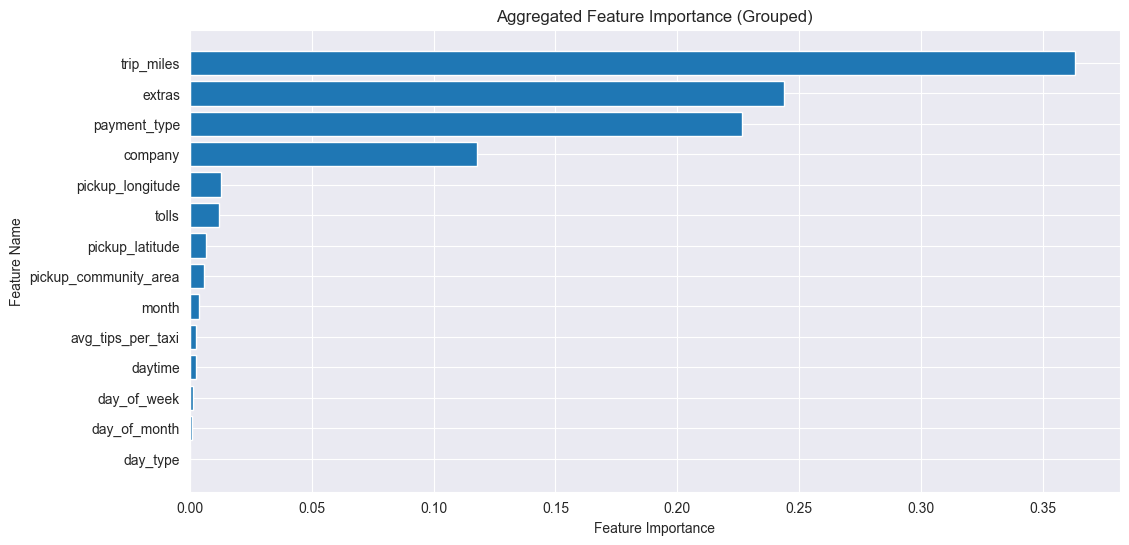

In [85]:
# Get feature importances from XGBoost model
feature_importances = pipeline.named_steps["model"].feature_importances_

# Retrieve transformed feature names from ColumnTransformer
encoder = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
ohe_feature_names = encoder.get_feature_names_out(categorical_cols)

# Combine numerical and encoded categorical feature names
all_feature_names = numerical_cols + list(ohe_feature_names)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": feature_importances
})

# Function to correctly map one-hot encoded features back to their original categorical column
def map_original_feature(feature_name):
    for cat_col in categorical_cols:
        if feature_name.startswith(cat_col + "_"):  # One-hot encoded feature
            return cat_col
    return feature_name  # Numerical features remain unchanged

# Apply the mapping function
feature_importance_df["Original Feature"] = feature_importance_df["Feature"].apply(map_original_feature)

# Aggregate importance scores by original feature names
aggregated_importance = feature_importance_df.groupby("Original Feature")["Importance"].sum().reset_index()

# Sort by importance
aggregated_importance = aggregated_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(aggregated_importance["Original Feature"], aggregated_importance["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Aggregated Feature Importance (Grouped)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Create a scatter plot for predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions", color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label="Perfect Fit")

# Labels and title
plt.xlabel("Actual Trip Total ($)")
plt.ylabel("Predicted Trip Total ($)")
plt.title("Predicted vs. Actual Trip Total")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
